In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import os
os.chdir('T:/Projects/LSTM-forecast/src')
import featureEng as fe
import processStocks as ps
import lstm
import getStocks
import visualize
import predicts

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14077968889610164151
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6814913823
locality {
  bus_id: 1
}
incarnation: 17779134465098577864
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [3]:
####TODO: reshaping so we can plot various n_in, n_out
# model seems to work, but cant redim for plot
ticker = 'unh'

n_in = 10
n_out = 5
target = 'Close'

In [9]:
import imp
imp.reload(getStocks)

<module 'getStocks' from 'T:\\Projects\\LSTM-forecast\\src\\getStocks.py'>

In [10]:
# collect a bunch of data from the market, save it to directory
# getStocks.get_mkt_data(source='yahoo')

In [34]:
# load dataset
#dataset = getStocks.get_single(ticker=ticker, save=True)
# dataset = getStocks.load_single(ticker)
dataset = getStocks.join_tgt_spt(target_ticker='UNH', number_spt=100)
dataset.reset_index(level=0, inplace=True)

#dataset.rename(columns={'Adj Close':'AdjCls'}, inplace=True)

In [35]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,NVDAOpen,NVDAHigh,NVDALow,...,KIMLow,KIMClose,KIMAdj Close,KIMVolume,KSUOpen,KSUHigh,KSULow,KSUClose,KSUAdj Close,KSUVolume
0,1984-10-17,0.144531,0.148438,0.144531,0.144531,0.126899,9868800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.916667,6.958333,6.875000,6.937500,2.771326,181200
1,1984-10-18,0.148438,0.156250,0.148438,0.148438,0.130329,5324800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.937500,6.979167,6.916667,6.979167,2.787970,21000
2,1984-10-19,0.148438,0.148438,0.144531,0.144531,0.126899,3043200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.000000,7.125000,7.000000,7.041667,2.812938,272400
3,1984-10-22,0.144531,0.148438,0.144531,0.144531,0.126899,2326400,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.041667,7.083333,6.916667,6.916667,2.763003,40200
4,1984-10-23,0.144531,0.144531,0.140625,0.140625,0.123469,787200,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.916667,7.083333,6.916667,6.916667,2.763003,175200


In [36]:
## Generate new features
dataset = fe.derivative(dataset, drop_na = True)
dataset = fe.weekDay(dataset)
features = list(dataset.columns)
# move target to position [-1]
features.remove(target)
features.append(target)
features=list(features)
dataset=dataset[features]

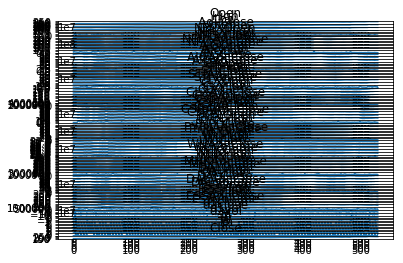

In [17]:
# Plot the features
visualize.plot_features(dataset)


In [37]:
# frame as supervised learning
# this will be for scaling the data to the window scaled_in to scaled_out
reframed=ps.series_to_supervised(dataset, n_in=n_in, n_out=n_out, 
                                   features=features)

starting Series to supverised conversion...


In [38]:
# drop all but the 'target' from the predictor set
# this might be able to take an array for multi-output
reframed=ps.frame_targets(reframed, features, n_out,target=target)

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(reframed)
# pass the feature in the sequence that we dont want scaled

In [28]:
#reframed=reframed.iloc[:10,:] #test/debug
#dataset=reframed
scaled=ps.scale_sequence(reframed, features, 
                         scaleTarget=True, target=target)

Scaling each sequence...
 Progress....1.09Sequence scaling complete.


In [39]:
scaled=reframed

In [21]:
#getStocks.saveScaled(scaled, n_in, n_out, ticker)
# load scaled 

#scaled=pd.read_csv('../data/astc/astc_29092017_scaled_30_30.csv')


# put in order of time (t-n_in should be on left of df, with t+ on the right)

# split into train, validation, test
train, validation, test = lstm.tscv(scaled, train=0.7, validation=0.25)

In [40]:
# split into input and outputs
# the last n columns are the output variable

train_X, train_y = train[:, :-n_out], train[:, -n_out:]
X_validation, Y_validation = validation[:, :-n_out], validation[:, -n_out:]
test_X, test_y = test[:, :-n_out], test[:, -n_out:]

In [41]:
# ensure the shaping makes sense the way all the variables are arranged
# reshape input to be 3D [samples(observations), timesteps (n_in), features]
train_X = ps.shape(train_X, n_in=n_in, features=features)
X_validation = ps.shape(X_validation, n_in=n_in, features=features)
test_X = ps.shape(test_X, n_in=n_in, features=features)

ValueError: cannot reshape array of size 270750 into shape (361,10,615)

In [ ]:
import imp
imp.reload(lstm)

In [ ]:
print(train_X.shape, X_validation.shape, test_X.shape)

In [ ]:
model = lstm.build_model(train_X, 
                         timesteps=n_in, 
                         inlayer=int(train_X.shape[-1]*20),
                         hiddenlayers=[60], 
                         outlayer=n_out)

In [ ]:
# fit network and save to history
history = model.fit(train_X, train_y, 
                    epochs=2500, 
                    batch_size=256, 
                    validation_data=(X_validation, Y_validation), 
                    verbose=2, shuffle=False)

# plot history
visualize.plot_loss(history)

In [ ]:
### KEEP THIS WORKING ####
yhat = predicts.predict_sequences_multiple(model, test_X, n_in, n_out)
visualize.plot_results_multiple(yhat, test_y[:,0], n_out, legend=False)
# visualize.plot_single(yhat, test_y, ticker, data_set_category='test')

In [ ]:
###### TODO METHOD####
#import predicts
## copy weights
#old_weights=model.get_weights()
#
#new_model = Sequential()
#new_model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2]),
#          return_sequences=True, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(LSTM(10, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(Dense(1))
#new_model.compile(loss='mae', optimizer='adam')
## fit network
#new_model.set_weights(old_weights)
#predicts.onlineForecast(new_model, test_X, test_y)
## # # ____ # # #